In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

import joblib

In [3]:
df = pd.read_csv("Datasets/plant_growth_dataset.csv")
df.head()

plant_species        date  plant_age_days  temperature   humidity  \
0   Arive-Dantu  2023-01-01              10    24.354431  52.994030   
1   Arive-Dantu  2023-01-02              10    23.921513  53.483883   
2   Arive-Dantu  2023-01-03              16    23.548990  52.616118   
3   Arive-Dantu  2023-01-04              20    23.818069  52.247005   
4   Arive-Dantu  2023-01-05              16    23.891465  54.646367   

   soil_moisture   soil_ph  light_intensity  height_cm  leaf_area_cm2  \
0      36.632859  7.046809     15589.751987   9.361922      26.532273   
1      37.028936  6.960871     15683.670310   9.371922      30.669019   
2      38.361623  7.015171     15798.653790   9.381922      33.182690   
3      39.367779  7.057316     16366.642237   9.391922      28.648229   
4      38.633777  7.012412     16514.012045   9.401922      29.153371   

   health_score  
0      0.738861  
1      0.706514  
2      0.668551  
3      0.641078  
4      0.605280

In [4]:
print("Null counts per column:\n", df.isnull().sum())
print("\nTotal null entries:", df.isnull().sum().sum())

# Drop rows with missing values (paper works with small clean dataset).
df = df.dropna().reset_index(drop=True)

# Remove duplicates
dups = df.duplicated().sum()
print("Duplicates found:", dups)
df = df.drop_duplicates().reset_index(drop=True)
print("Shape after dropna & dedupe:", df.shape)

Null counts per column:
 plant_species      0
date               0
plant_age_days     0
temperature        0
humidity           0
soil_moisture      0
soil_ph            0
light_intensity    0
height_cm          0
leaf_area_cm2      0
health_score       0
dtype: int64

Total null entries: 0
Duplicates found: 0
Shape after dropna & dedupe: (14992, 11)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14992 entries, 0 to 14991
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   plant_species    14992 non-null  object 
 1   date             14992 non-null  object 
 2   plant_age_days   14992 non-null  int64  
 3   temperature      14992 non-null  float64
 4   humidity         14992 non-null  float64
 5   soil_moisture    14992 non-null  float64
 6   soil_ph          14992 non-null  float64
 7   light_intensity  14992 non-null  float64
 8   height_cm        14992 non-null  float64
 9   leaf_area_cm2    14992 non-null  float64
 10  health_score     14992 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 1.3+ MB


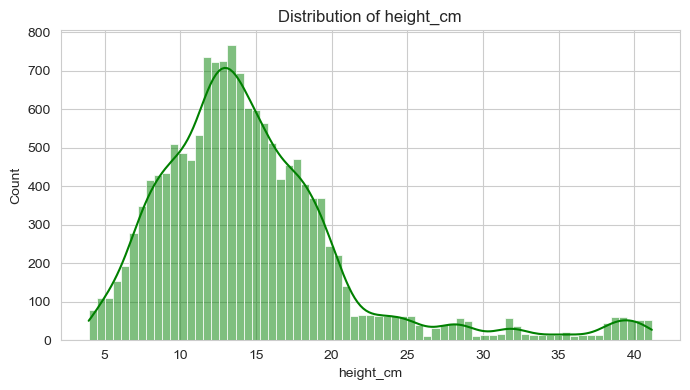

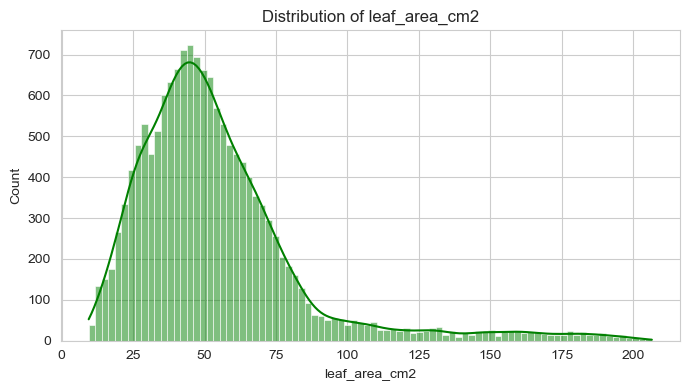

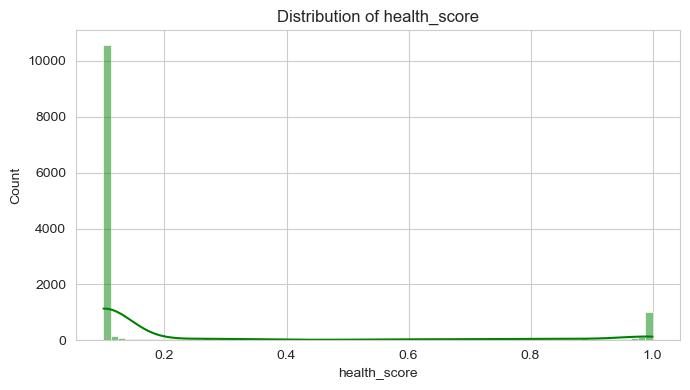

In [6]:
targets = df[["height_cm", "leaf_area_cm2", "health_score"]]

for col in targets.columns:
    plt.figure(figsize=(7,4))
    sns.histplot(df[col], kde=True, color="green")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


<Figure size 1000x600 with 0 Axes>

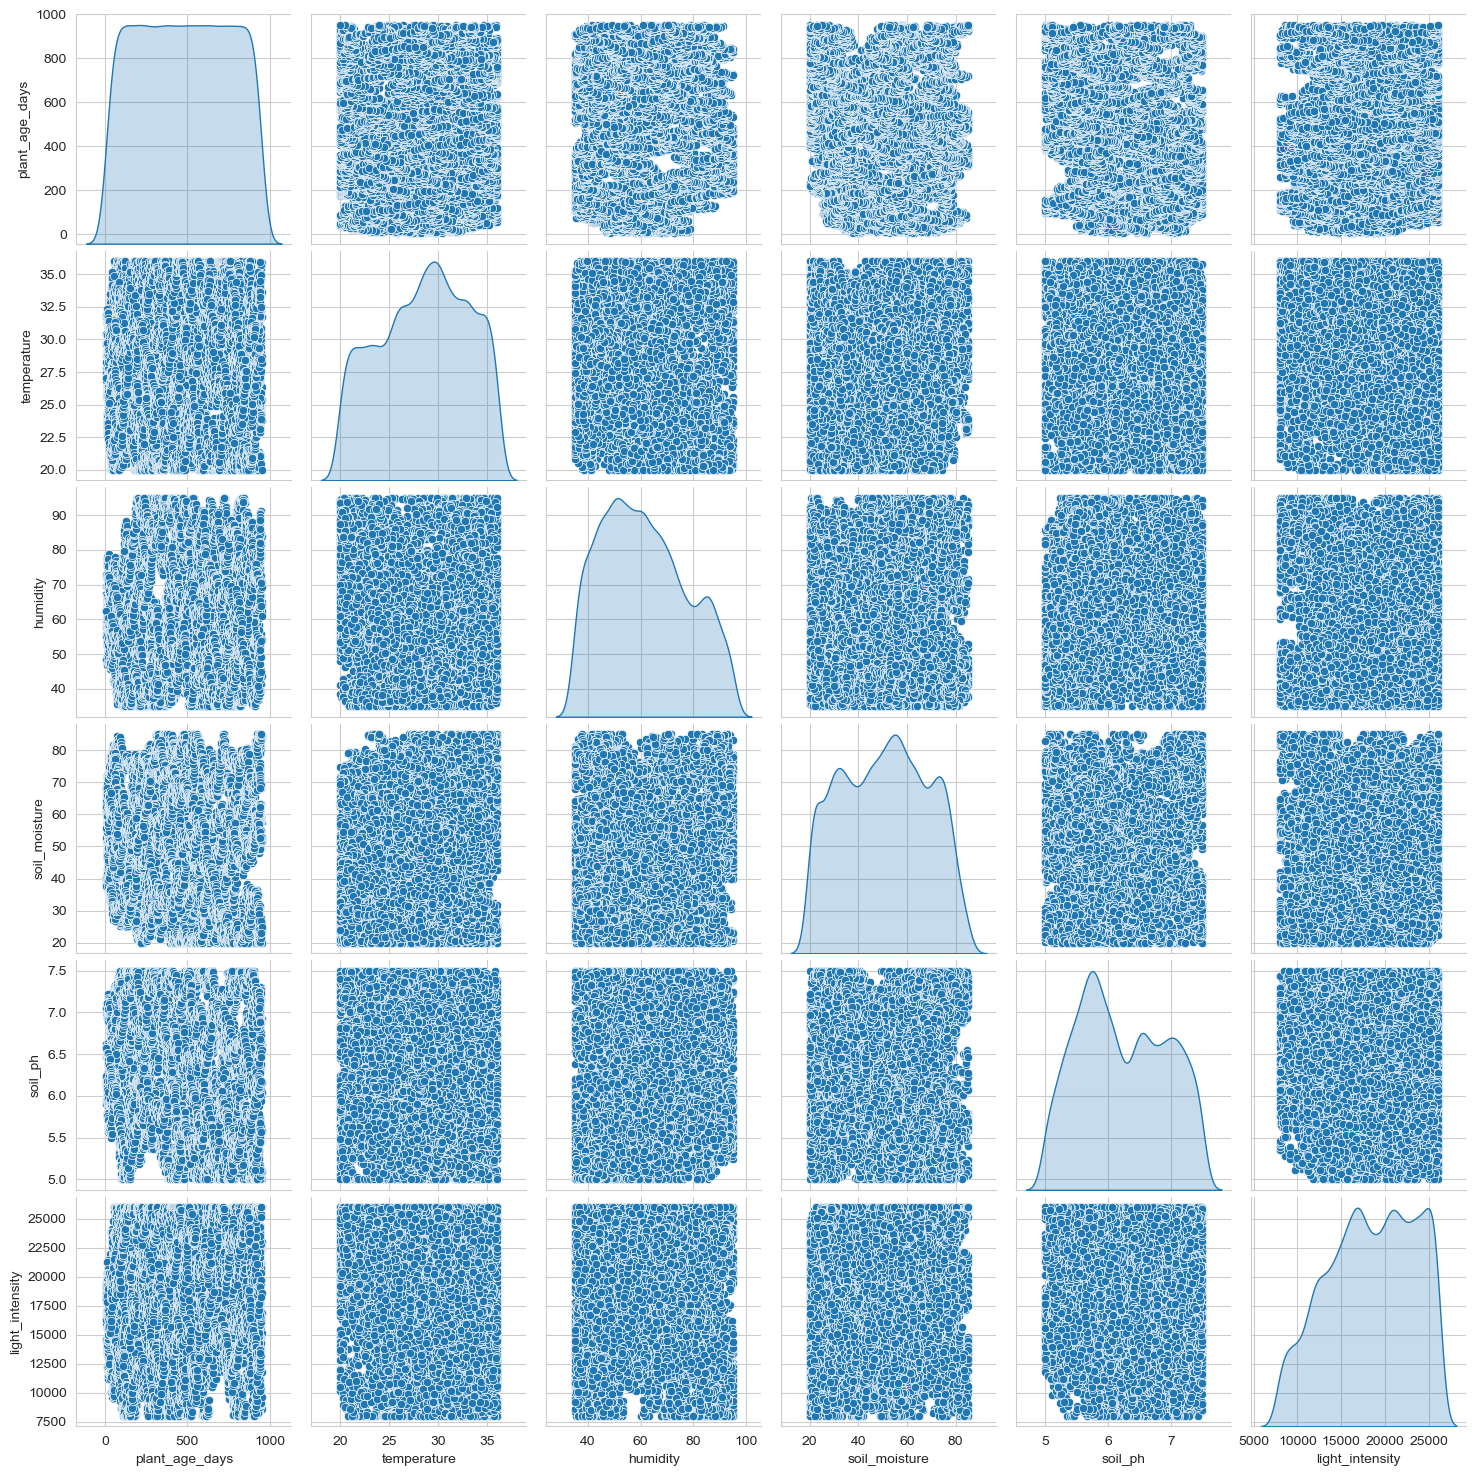

In [7]:
plt.figure(figsize=(10,6))
sns.pairplot(df[[
    "plant_age_days", "temperature", "humidity",
    "soil_moisture", "soil_ph", "light_intensity"
]], diag_kind="kde")
plt.show()

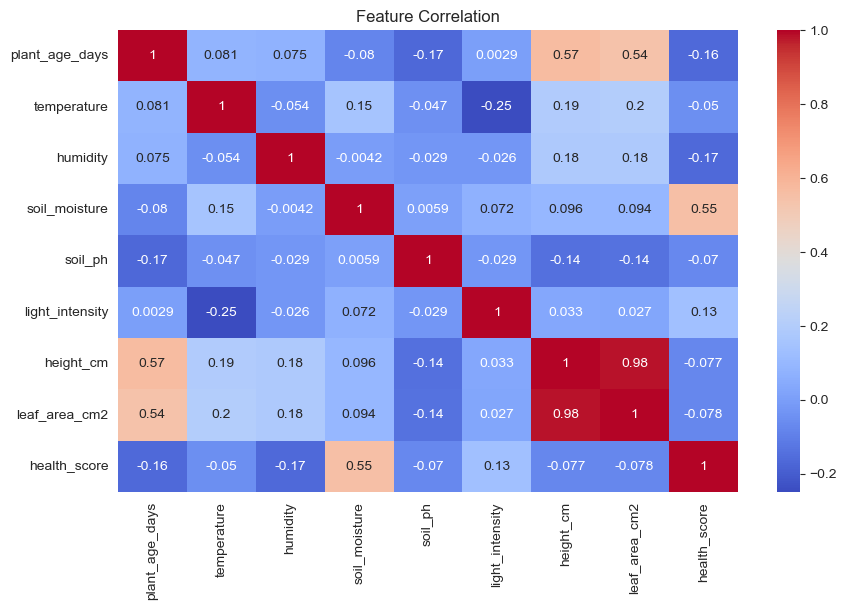

In [8]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

# Label Encoding

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["plant_species"] = le.fit_transform(df["plant_species"])

import joblib
joblib.dump(le, "Models/label_encoder.sav")

['Models/label_encoder.sav']

In [10]:
X = df[[
    "plant_species", "plant_age_days",
    "temperature", "humidity", "soil_moisture", "soil_ph", "light_intensity"
]]
y = df[["height_cm", "leaf_area_cm2", "health_score"]]

# Train-Test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=200)

In [12]:
model_results = {} 

def regression_metrics(y_true, y_pred, verbose=True):

    results = {}

    for i, col in enumerate(y_true.columns):
        yt = y_true[col].values
        yp = y_pred[:, i]

        evar = explained_variance_score(yt, yp)
        mae = mean_absolute_error(yt, yp)
        mse = mean_squared_error(yt, yp)
        rmse = np.sqrt(mse)
        r2 = r2_score(yt, yp)

        results[col] = {
            "EVAR": evar,
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2
        }

        if verbose:
            print(f"\n===== {col} =====")
            print(f"EVAR: {evar:.4f}")
            print(f"MAE:  {mae:.4f}")
            print(f"RMSE: {rmse:.4f}")
            print(f"R2:   {r2:.4f}")

    return results

def plot_actual_vs_predicted(y_true, y_pred, title_prefix="Actual vs Predicted"):
    for i, col in enumerate(y_true.columns):
        plt.figure(figsize=(7, 6))
        plt.scatter(y_true[col], y_pred[:, i], alpha=0.6)
        
        mn = min(y_true[col].min(), y_pred[:, i].min())
        mx = max(y_true[col].max(), y_pred[:, i].max())
        plt.plot([mn, mx], [mn, mx], "r--", lw=2)  

        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"{title_prefix} - {col}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# XGBoost


===== height_cm =====
EVAR: 0.9971
MAE:  0.1862
RMSE: 0.3440
R2:   0.9971

===== leaf_area_cm2 =====
EVAR: 0.9637
MAE:  4.1007
RMSE: 5.5724
R2:   0.9637

===== health_score =====
EVAR: 0.9882
MAE:  0.0174
RMSE: 0.0332
R2:   0.9882


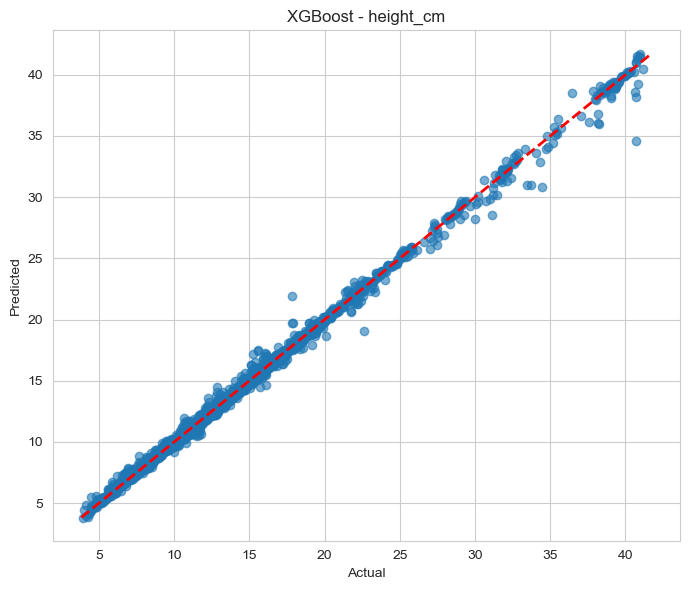

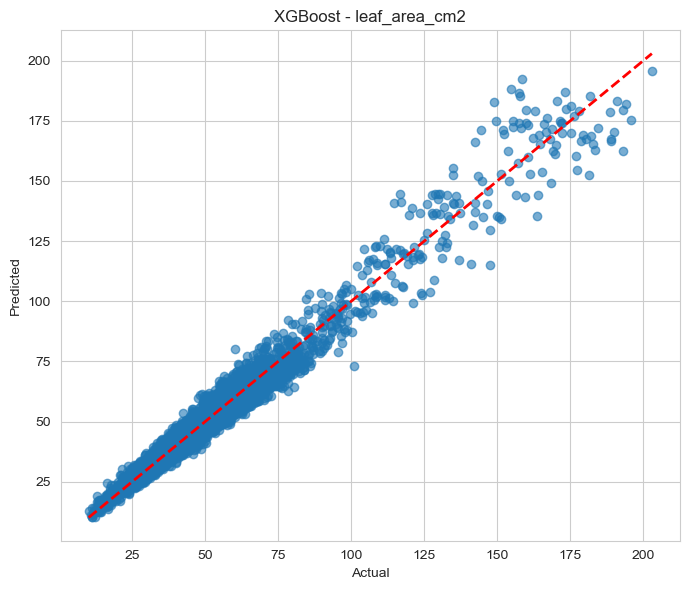

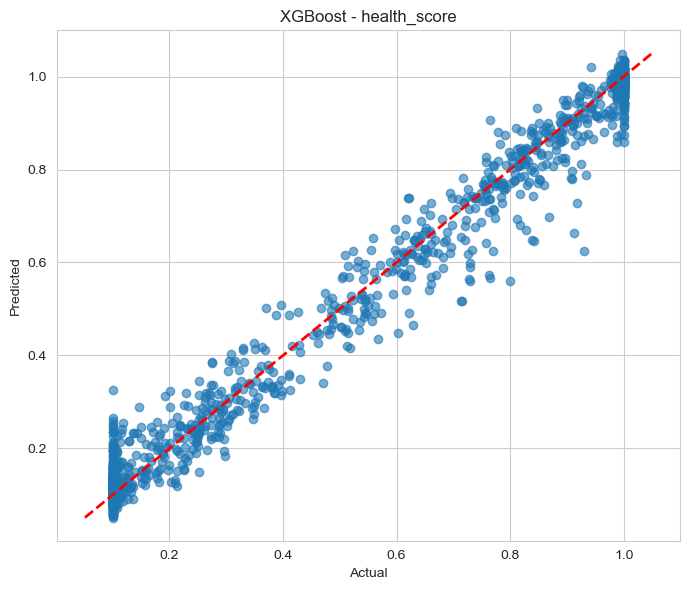

In [13]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    random_state=42,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    n_jobs=-1,
    verbosity=0,
    tree_method="hist"
)

xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)
metrics_xgb = regression_metrics(y_test, y_pred_xgb, verbose=True)
plot_actual_vs_predicted(y_test, y_pred_xgb, "XGBoost")

In [14]:
model_results["XGBoost"] = metrics_xgb

# RandomForest


===== height_cm =====
EVAR: 0.9962
MAE:  0.1116
RMSE: 0.3948
R2:   0.9962

===== leaf_area_cm2 =====
EVAR: 0.9620
MAE:  4.0946
RMSE: 5.6982
R2:   0.9620

===== health_score =====
EVAR: 0.9933
MAE:  0.0119
RMSE: 0.0251
R2:   0.9933


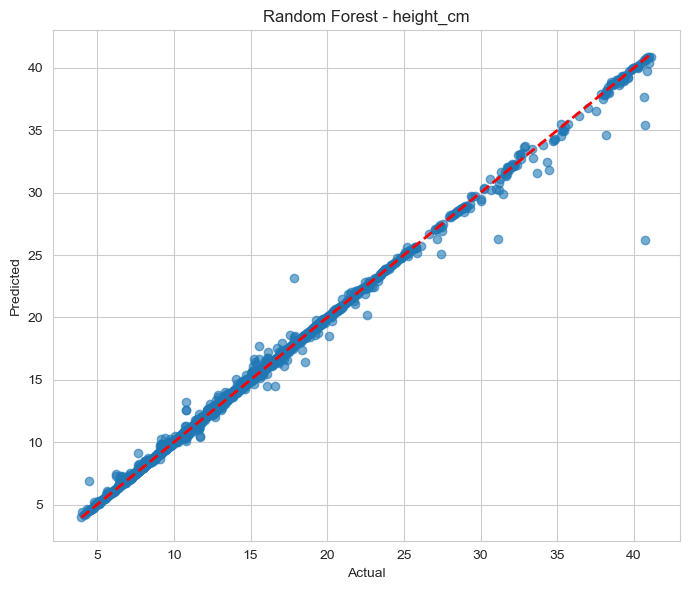

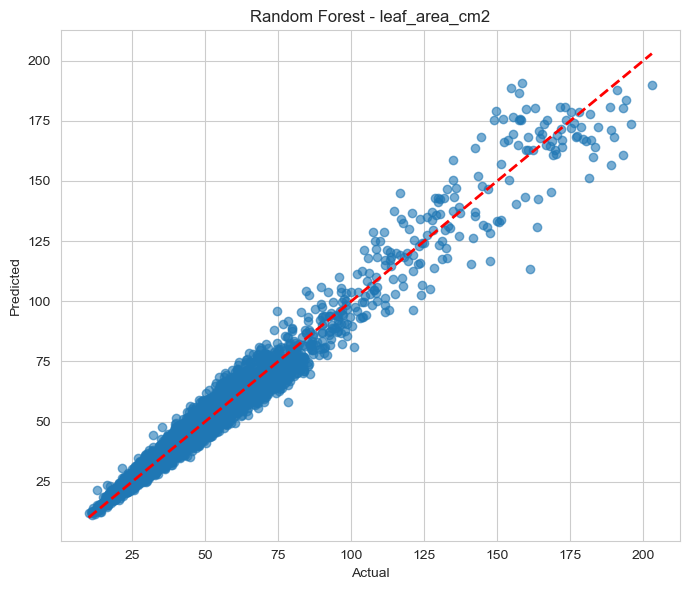

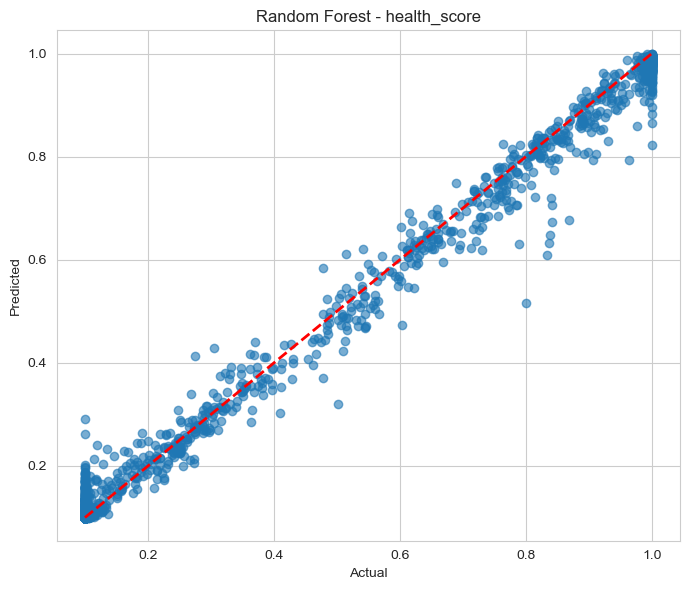

In [15]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
metrics_rf = regression_metrics(y_test, y_pred_rf, verbose=True)
plot_actual_vs_predicted(y_test, y_pred_rf, "Random Forest")

In [16]:
model_results["RandomForest"] = metrics_rf

# Gradient Boosting


===== height_cm =====
EVAR: 0.9768
MAE:  0.6406
RMSE: 0.9758
R2:   0.9768

===== leaf_area_cm2 =====
EVAR: 0.9445
MAE:  4.9374
RMSE: 6.8879
R2:   0.9445

===== health_score =====
EVAR: 0.9167
MAE:  0.0502
RMSE: 0.0884
R2:   0.9166


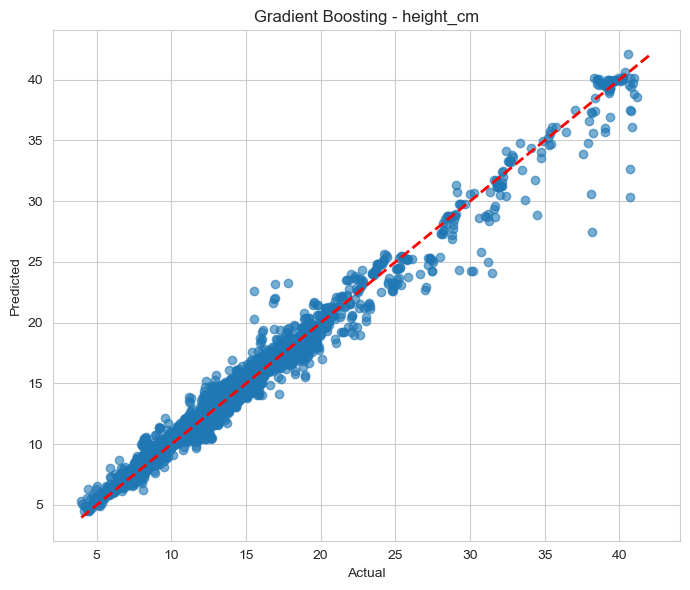

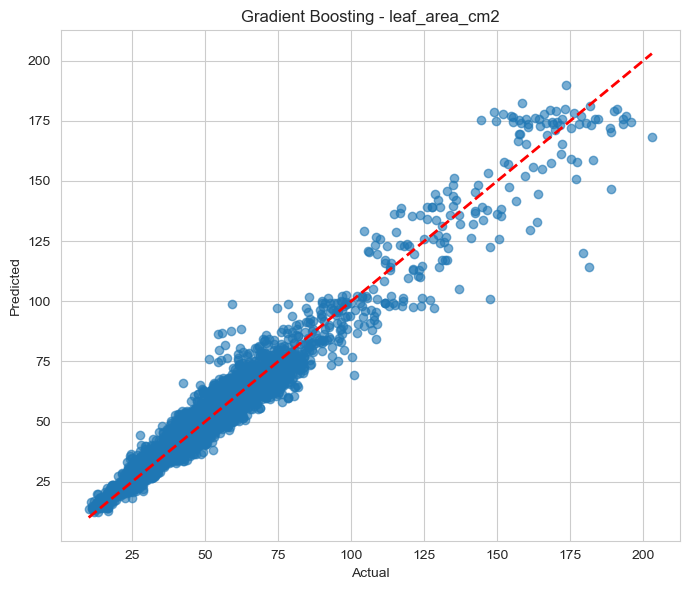

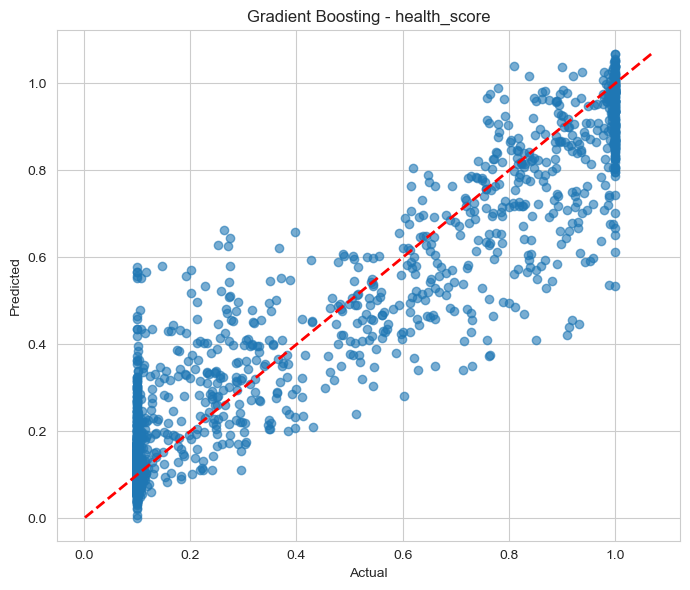

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

gbr_base = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbr = MultiOutputRegressor(gbr_base)

gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
metrics_gbr = regression_metrics(y_test, y_pred_gbr, verbose=True)
plot_actual_vs_predicted(y_test, y_pred_gbr, "Gradient Boosting")

In [18]:
model_results["GradientBoosting"] = metrics_gbr

# Decision Tree


===== height_cm =====
EVAR: 0.9812
MAE:  0.1532
RMSE: 0.8796
R2:   0.9811

===== leaf_area_cm2 =====
EVAR: 0.9178
MAE:  5.3956
RMSE: 8.3782
R2:   0.9178

===== health_score =====
EVAR: 0.9589
MAE:  0.0141
RMSE: 0.0621
R2:   0.9589


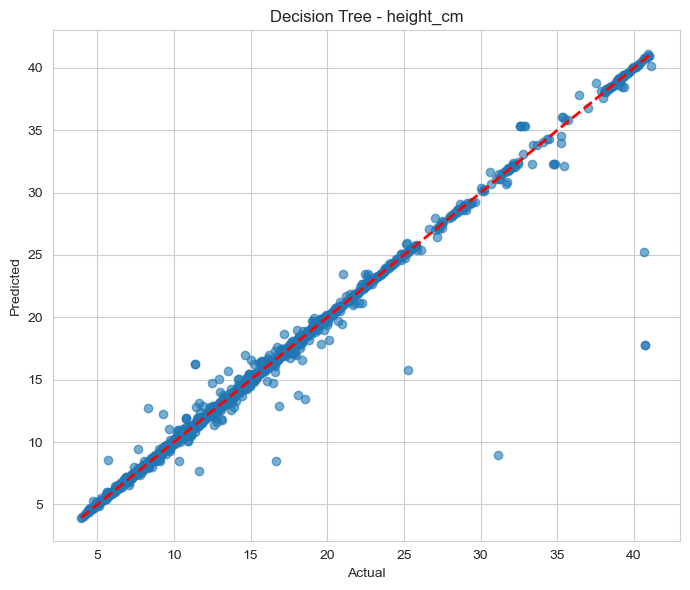

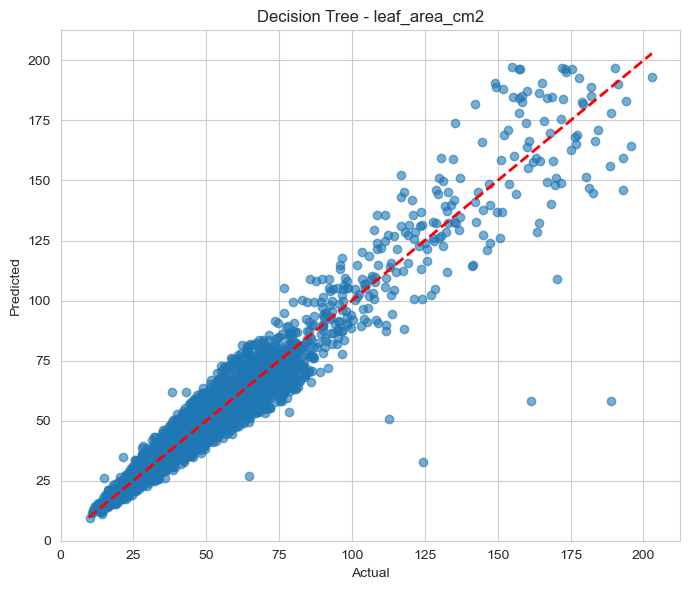

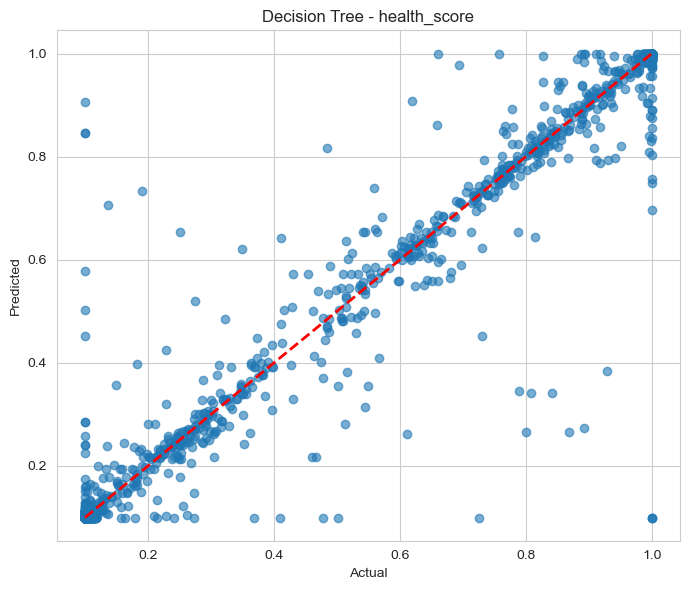

In [19]:
from sklearn.tree import DecisionTreeRegressor


dt = DecisionTreeRegressor(
    max_depth=None,  # full growth
    min_samples_split=2,
    random_state=42
)

dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
metrics_dt = regression_metrics(y_test, y_pred_dt, verbose=True)
plot_actual_vs_predicted(y_test, y_pred_dt, "Decision Tree")

In [20]:
model_results["DecisionTree"] = metrics_dt

# LightGBM

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1546
[LightGBM] [Info] Number of data points in the train set: 11993, number of used features: 7
[LightGBM] [Info] Start training from score 14.747418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

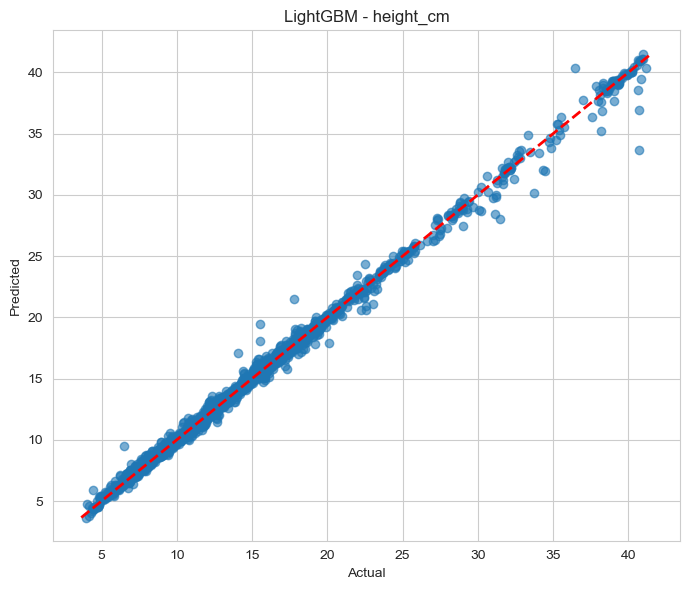

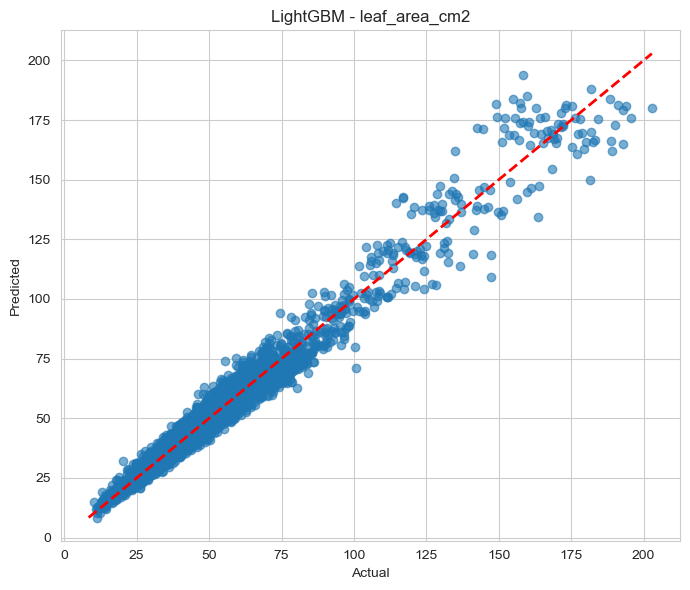

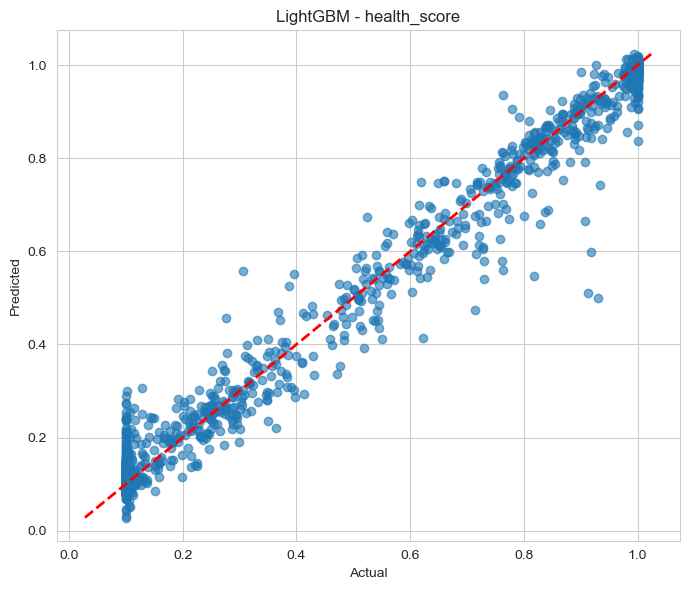

In [21]:
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor

lgb_base = lgb.LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

lgb_model = MultiOutputRegressor(lgb_base)

lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
metrics_lgb = regression_metrics(y_test, y_pred_lgb, verbose=True)
plot_actual_vs_predicted(y_test, y_pred_lgb, "LightGBM")

In [22]:
model_results["LightGBM"] = metrics_lgb

# Stacking Regressor


===== height_cm =====
EVAR: 0.9960
MAE:  0.2369
RMSE: 0.4037
R2:   0.9960

===== leaf_area_cm2 =====
EVAR: 0.9619
MAE:  4.1810
RMSE: 5.7059
R2:   0.9619

===== health_score =====
EVAR: 0.9877
MAE:  0.0132
RMSE: 0.0340
R2:   0.9877


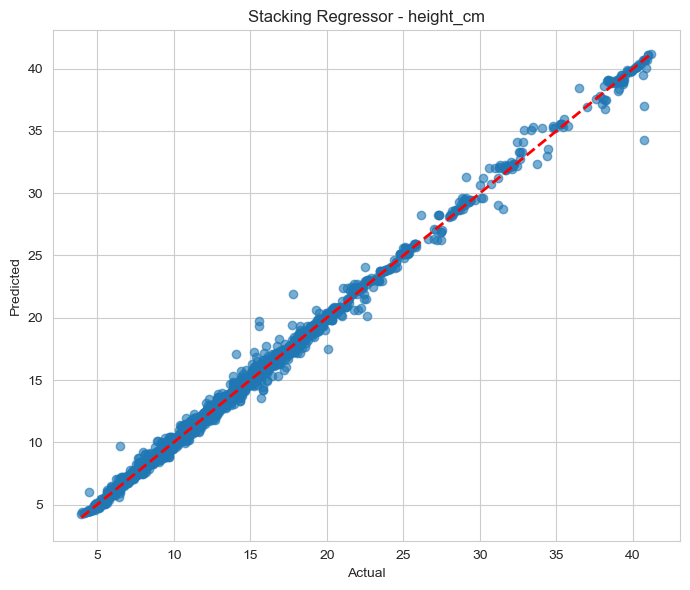

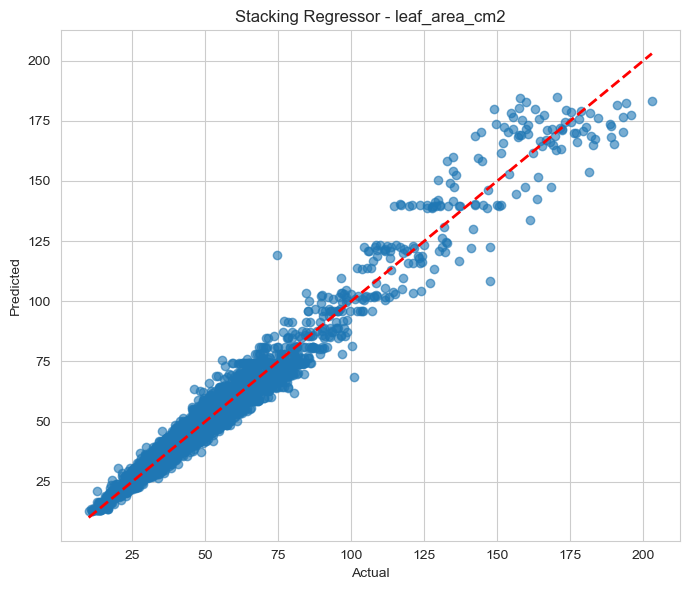

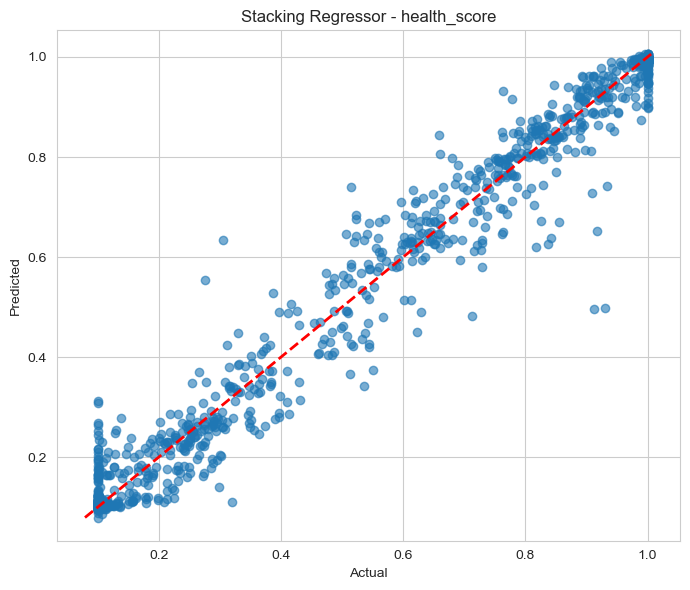

In [23]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor

estimators = [
    ('gbr', GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42)),
    ('lgb', lgb.LGBMRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1))
]

stacking_model_base = StackingRegressor(
    estimators=estimators,
    final_estimator=GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42),
    n_jobs=-1,
    passthrough=True
)

stacking_model = MultiOutputRegressor(stacking_model_base)
stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)
metrics_stack = regression_metrics(y_test, y_pred_stack, verbose=True)
plot_actual_vs_predicted(y_test, y_pred_stack, "Stacking Regressor")

In [24]:
model_results["StackingRegressor"] = metrics_stack

# Comparison Table

In [25]:
import pandas as pd

def results_to_dataframe(model_results):
    rows = []

    for model_name, targets in model_results.items():
        for target_name, metrics in targets.items():
            row = {
                "Model": model_name,
                "Target": target_name,
                "EVAR": metrics["EVAR"],
                "MAE": metrics["MAE"],
                "RMSE": metrics["RMSE"],
                "R2": metrics["R2"]
            }
            rows.append(row)

    return pd.DataFrame(rows)


In [26]:
results_df = results_to_dataframe(model_results)
results_df

Model         Target      EVAR       MAE      RMSE        R2
0             XGBoost      height_cm  0.997116  0.186157  0.344022  0.997116
1             XGBoost  leaf_area_cm2  0.963671  4.100737  5.572361  0.963655
2             XGBoost   health_score  0.988236  0.017361  0.033235  0.988228
3        RandomForest      height_cm  0.996202  0.111580  0.394814  0.996202
4        RandomForest  leaf_area_cm2  0.961995  4.094585  5.698208  0.961995
5        RandomForest   health_score  0.993270  0.011899  0.025132  0.993268
6    GradientBoosting      height_cm  0.976807  0.640644  0.975848  0.976797
7    GradientBoosting  leaf_area_cm2  0.944527  4.937406  6.887915  0.944469
8    GradientBoosting   health_score  0.916674  0.050182  0.088441  0.916640
9        DecisionTree      height_cm  0.981166  0.153185  0.879646  0.981146
10       DecisionTree  leaf_area_cm2  0.917841  5.395609  8.378197  0.917839
11       DecisionTree   health_score  0.958929  0.014121  0.062090  0.958914
12           LightGBM      height_cm  0.996277  0.215443  0.390871  0.996277
13           LightGBM  leaf_area_cm2  0.963024  4.110885  5.621820  0.963007
14           LightGBM   health_score  0.987562  0.016455  0.034167  0.987559
15  StackingRegressor      height_cm  0.996037  0.236927  0.403688  0.996029
16  StackingRegressor  leaf_area_cm2  0.961937  4.180993  5.705871  0.961893
17  StackingRegressor   health_score  0.987687  0.013176  0.033991  0.987687

# Save the model

In [27]:
import os
import joblib

os.makedirs("Models", exist_ok=True)

joblib.dump(stacking_model, "Models/growth_pred_model.sav")

['Models/growth_pred_model.sav']

# Comparison Graph

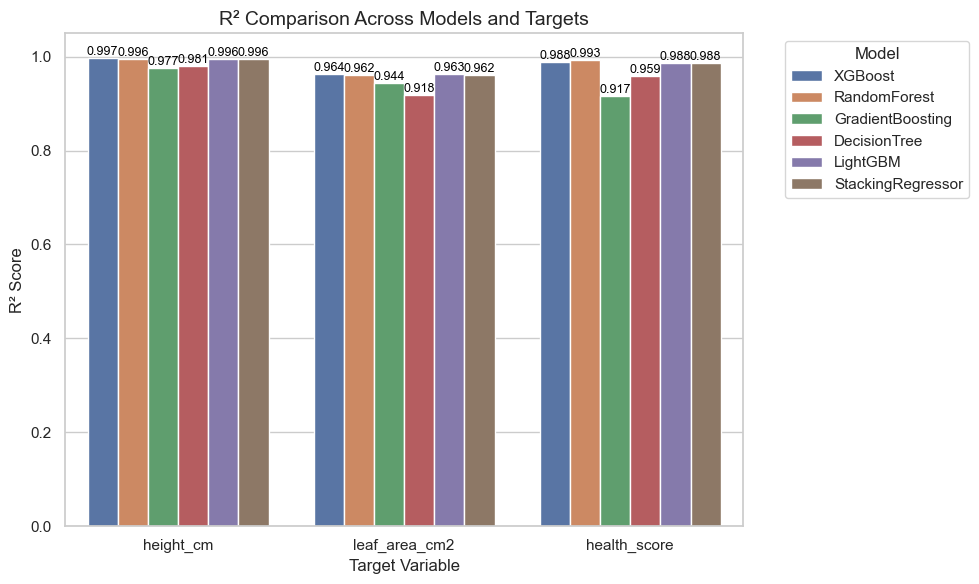

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

df_melt = results_df.melt(
    id_vars=["Model", "Target"],
    value_vars=["EVAR", "MAE", "RMSE", "R2"],
    var_name="Metric",
    value_name="Value"
)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_melt[df_melt["Metric"]=="R2"],
    x="Target",
    y="Value",
    hue="Model"
)
plt.title("R² Comparison Across Models and Targets", fontsize=14)
plt.ylim(0, 1.05)
plt.ylabel("R² Score")
plt.xlabel("Target Variable")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.3f}", 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9, color='black', rotation=0)

plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

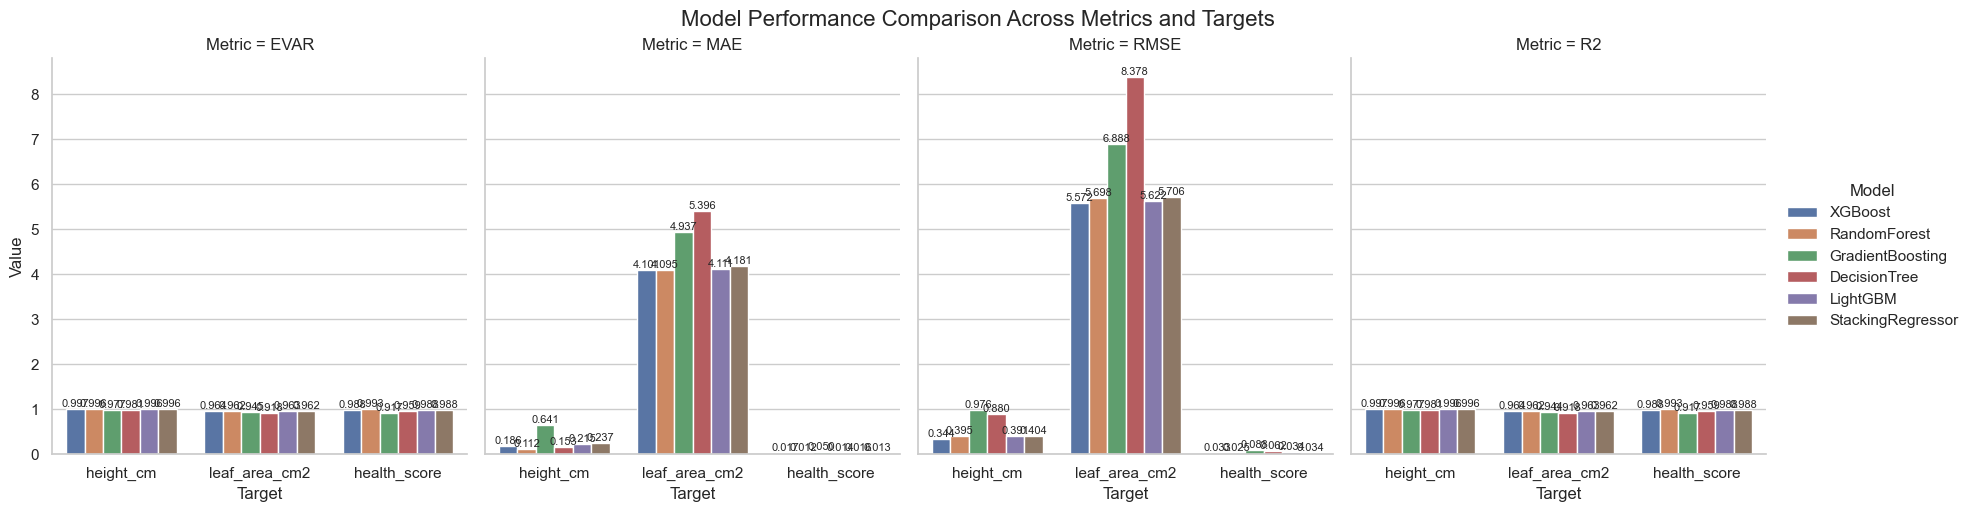

In [29]:
g = sns.catplot(
    data=df_melt,
    x="Target",
    y="Value",
    hue="Model",
    col="Metric",
    kind="bar",
    height=5,
    aspect=0.9
)

for ax in g.axes.flat:
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f"{height:.3f}", 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=8, rotation=0)

g.fig.suptitle("Model Performance Comparison Across Metrics and Targets", fontsize=16, y=1.02)
plt.show()
